<a href="https://colab.research.google.com/github/aaronmj7/Assignment-3-LLM/blob/main/Assignment_3_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 3 - Large language models**

In [ ]:
# Install necessary libraries
!pip install datasets evaluate transformers[sentencepiece]
# Clear the output
from IPython.display import clear_output
clear_output()

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification, create_optimizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [ ]:
sns.set_theme()

warnings.filterwarnings('ignore')

## Load Data

In [ ]:
# Load dataset
raw_ds = load_dataset("OxAISH-AL-LLM/wiki_toxic")

Generating train split:   0%|          | 0/127656 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31915 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/63978 [00:00<?, ? examples/s]

Generating balanced_train split:   0%|          | 0/25868 [00:00<?, ? examples/s]

In [ ]:
raw_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 25868
    })
})

In [ ]:
raw_ds["train"].features

{'id': Value(dtype='string', id=None),
 'comment_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['non', 'tox'], id=None)}

In [ ]:
label_names = raw_ds["train"].features['label'].names
label_names

['non', 'tox']

In [ ]:
raw_ds["train"][0]

{'id': '794c30aff0931384',
 'comment_text': "And that's not a personal attack^^ ?",
 'label': 0}

In [ ]:
ds = raw_ds["balanced_train"]
ds

Dataset({
    features: ['id', 'comment_text', 'label'],
    num_rows: 25868
})

In [ ]:
ds[:5]

{'id': ['653b15d1deea659e',
  '57c5f0e88e9e5219',
  'e78a6eb06dbddd9a',
  '435008cc6f750098',
  '2c60f0fc97d86718'],
 'comment_text': ['"\nNot if I can help it. Mudslide is more like it....127 "',
  'Footnotes/references\nOk. I have no objection',
  '.\nI am a loser and I need your help to get a life',
  '"\nI think I\'ve decided that I have no strong opinion. As long as the style doesn\'t have any of the old problems, it doesn\'t matter to me if it\'s substed or transcluded. Just no metadata, no hide/show, and no junk links. -  (conspire | past ops) "',
  'Quite frankly nothing is helping due to his arrogance and truculence. He keeps getting called a dick as he is acting like one, over and over. In my view that makes him one. Thank you for posting my comment over to the IB. Incidentally, what makes you think a block will cure anything?'],
 'label': [0, 0, 0, 0, 1]}

## EDA

In [ ]:
# Convert dataset to DataFrame
ds.set_format("pandas")
df = ds[:]

# Reset dataset format
ds.reset_format()

# Display first few rows
df.head()

,id,comment_text,label
0,653b15d1deea659e,"""\nNot if I can help it. Mudslide is more like...",0
1,57c5f0e88e9e5219,Footnotes/references\nOk. I have no objection,0
2,e78a6eb06dbddd9a,.\nI am a loser and I need your help to get a ...,0
3,435008cc6f750098,"""\nI think I've decided that I have no strong ...",0
4,2c60f0fc97d86718,Quite frankly nothing is helping due to his ar...,1


In [ ]:
try:
    df.drop(columns=['id'], inplace=True)
except KeyError:
    pass
df.head()

,comment_text,label
0,"""\nNot if I can help it. Mudslide is more like...",0
1,Footnotes/references\nOk. I have no objection,0
2,.\nI am a loser and I need your help to get a ...,0
3,"""\nI think I've decided that I have no strong ...",0
4,Quite frankly nothing is helping due to his ar...,1


label
0    12934
1    12934
Name: count, dtype: int64


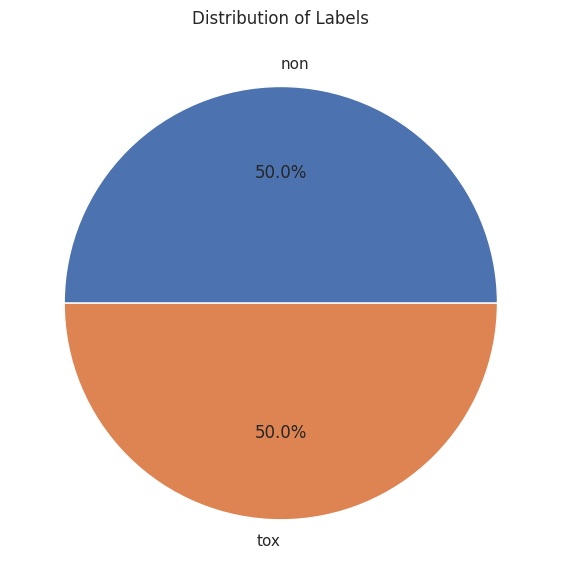

In [ ]:
# Calculate the proportions of each label
label_counts = df['label'].value_counts()
sizes = label_counts.values.tolist()
print(label_counts)

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=label_names, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.tight_layout()
plt.show()

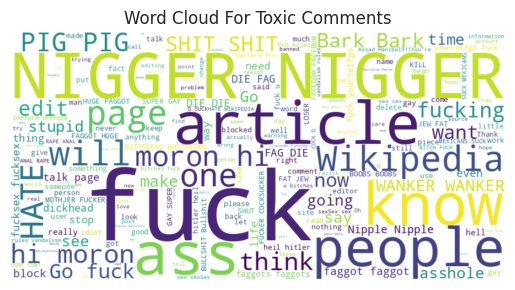

In [ ]:
from wordcloud import WordCloud

toxic_comments = ''.join(df[df['label'] == 1]['comment_text'])
toxic_words = WordCloud(width = 900, height = 450, background_color = "white").generate(toxic_comments)
plt.imshow(toxic_words, interpolation = 'bilinear')
plt.axis("off")
plt.title("Word Cloud For Toxic Comments")
plt.show()

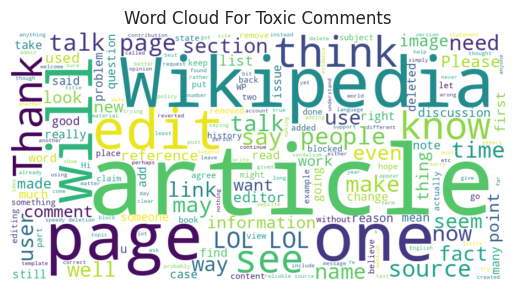

In [ ]:
non_toxic_comments = ''.join(df[df['label'] == 0]['comment_text'])
non_toxic_words = WordCloud(width = 900, height = 450, background_color = "white").generate(non_toxic_comments)
plt.imshow(non_toxic_words, interpolation = 'bilinear')
plt.axis("off")
plt.title("Word Cloud For Toxic Comments")
plt.show()

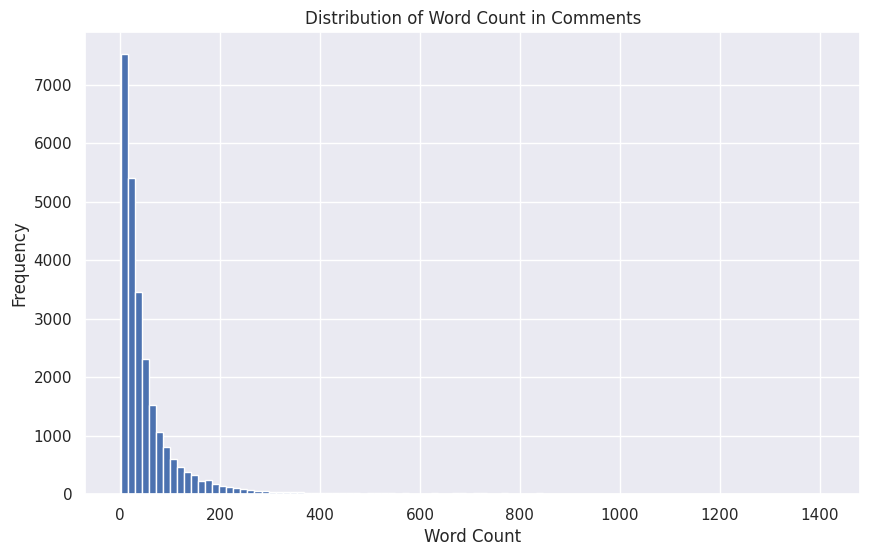

In [ ]:
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# Plotting the distribution
plt.figure(figsize=(10,6))
df['word_count'].hist(bins=100)
plt.title('Distribution of Word Count in Comments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df['word_count'].describe()

,word_count
count,25868.000000
mean,60.085666
std,101.457404
min,1.000000
25%,13.000000
50%,29.000000
75%,63.000000
max,1411.000000


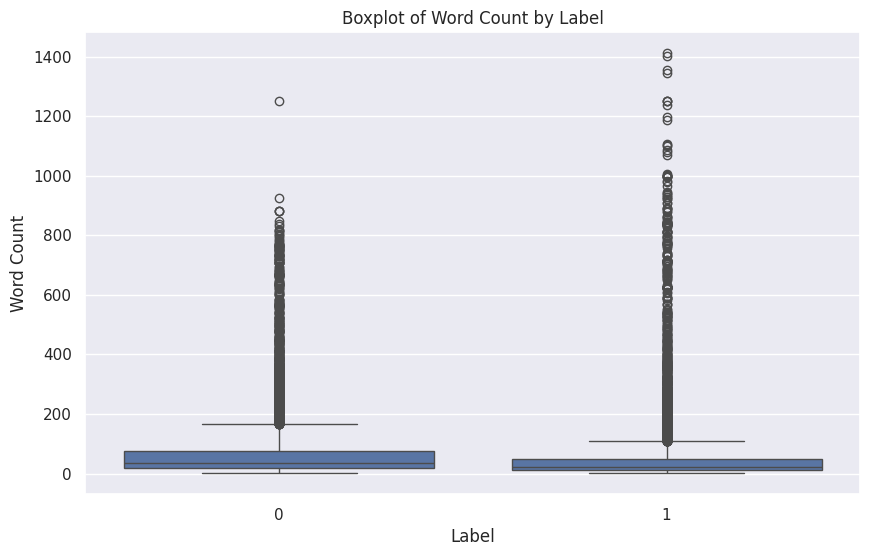

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='word_count', data=df)
plt.title('Boxplot of Word Count by Label')
plt.xlabel('Label')
plt.ylabel('Word Count')
plt.show()

## Pre-processing

In [ ]:
# Set model checkpoint
model_checkpoint = "distilbert-base-uncased"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Check if it is a fast tokenizer
tokenizer.is_fast

True

In [ ]:
tokenizer.model_max_length

512

In order to run our experiments on GPUs found on Google Colab, we’ll pick something a bit smaller.

In [ ]:
# Tokenize a comment
inputs = tokenizer(ds[0]['comment_text'], truncation=True, max_length=128)
inputs

{'input_ids': [101, 1000, 2025, 2065, 1045, 2064, 2393, 2009, 1012, 8494, 14540, 5178, 2003, 2062, 2066, 2009, 1012, 1012, 1012, 1012, 13029, 1000, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))
print(ds[0]['comment_text'])

['[CLS]', '"', 'not', 'if', 'i', 'can', 'help', 'it', '.', 'mud', '##sl', '##ide', 'is', 'more', 'like', 'it', '.', '.', '.', '.', '127', '"', '[SEP]']
"
Not if I can help it. Mudslide is more like it....127 "


In [ ]:
ds = ds.train_test_split(test_size=0.2, seed=73)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 20694
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 5174
    })
})

In [ ]:
# Define a function to tokenize
def tokenize(ex):
    return tokenizer(ex["comment_text"], truncation=True, max_length=128)

In [ ]:
tokenized_ds = ds.map(tokenize, batched=True)
tokenized_ds

Map:   0%|          | 0/20694 [00:00<?, ? examples/s]

Map:   0%|          | 0/5174 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 20694
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5174
    })
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
samples = tokenized_ds["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["id", "comment_text"]}
[len(x) for x in samples["input_ids"]]

[12, 29, 11, 38, 125, 128, 128, 80]

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': TensorShape([8, 128]),
 'attention_mask': TensorShape([8, 128]),
 'labels': TensorShape([8])}

In [ ]:
train_dataset = tokenized_ds["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)

valid_dataset = tokenized_ds["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=16,
)

In [ ]:
valid_dataset.element_spec

({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

## Model

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_epochs = 3
num_train_steps = len(train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=1e-6,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=num_epochs,
                    )

Epoch 1/3
1294/1294 [==============================] - 356s 261ms/step - loss: 0.3897 - accuracy: 0.8430 - val_loss: 0.2216 - val_accuracy: 0.9206
Epoch 2/3
1294/1294 [==============================] - 334s 258ms/step - loss: 0.2145 - accuracy: 0.9198 - val_loss: 0.1972 - val_accuracy: 0.9260
Epoch 3/3
1294/1294 [==============================] - 333s 257ms/step - loss: 0.1998 - accuracy: 0.9265 - val_loss: 0.1934 - val_accuracy: 0.9283


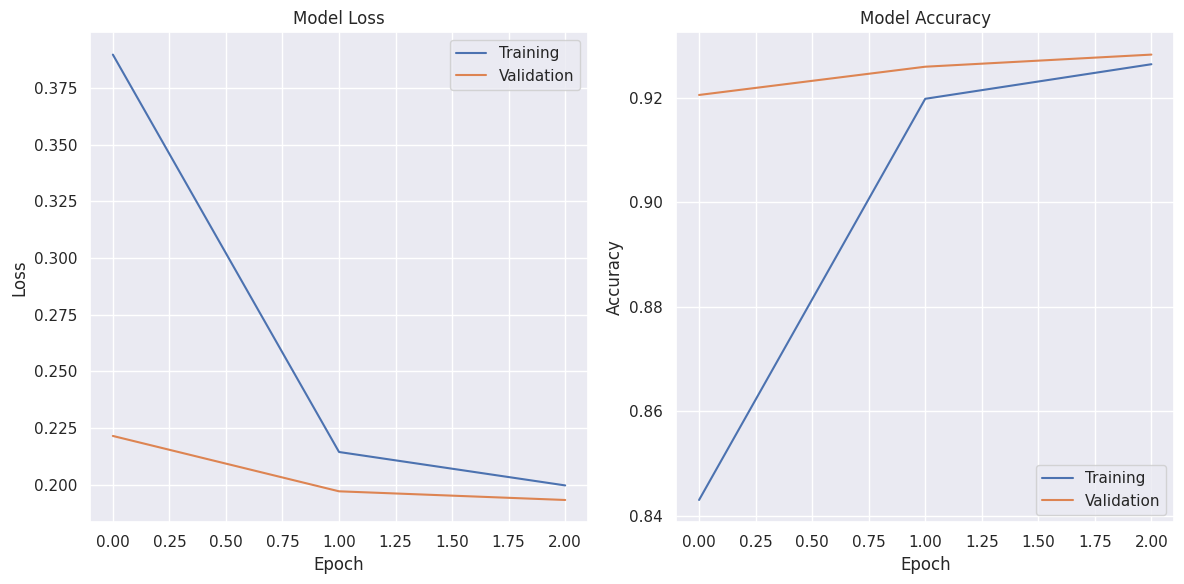

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

# Plot training and validation accuracy
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
model.save_weights('/content/drive/MyDrive/llm_model.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/llm_model.h5')

In [83]:
Pred = model.predict(valid_dataset)
Pred = np.argmax(Pred.logits, axis=1)

324/324 [==============================] - 28s 85ms/step


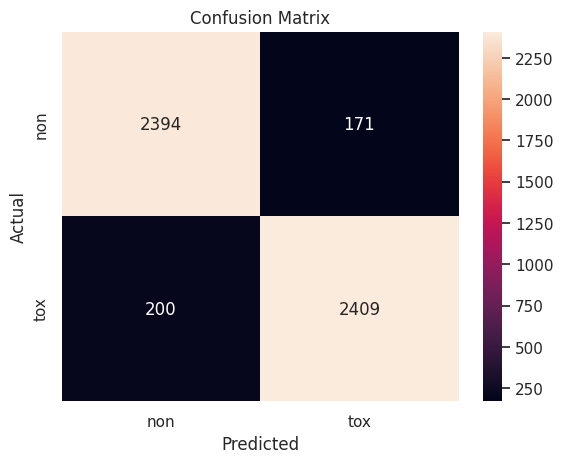

In [84]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.concatenate([y for x, y in valid_dataset])
y_pred = Pred

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='rocket', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [85]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

Classification Report:
              precision    recall  f1-score   support

         non       0.92      0.93      0.93      2565
         tox       0.93      0.92      0.93      2609

    accuracy                           0.93      5174
   macro avg       0.93      0.93      0.93      5174
weighted avg       0.93      0.93      0.93      5174



In [88]:
# initiate tokenizer
tokenizer.from_pretrained('distilbert-base-uncased')

import tensorflow as tf

# Define function that predict the class label
def predict(text):
    """
    function that predict the class label for a text

    Args:
    text: a movie review that needs to be classified

    returns:
    predicted_class and predicted probability
    """
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=512)

    # Model prediction
    prediction = model(inputs)
    logits = prediction['logits'].numpy()

    # Convert logits to probabilities
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]

    # Get the predicted class and its probability
    predicted_class = np.argmax(probabilities)
    predicted_probability = probabilities[predicted_class]

    return predicted_class, predicted_probability


# Define a function `on_button_click` that is called when a button is pressed.
def on_button_click(button):
    # Clear the previous output from the display.
    clear_output(wait=True)

    # Call the `predict` function
    # The `predict` function returns two values: a prediction (either 1 or 0) and a probability.
    prediction, probability = predict(text_area.value)

    # If the prediction is 1, then print that the input text is predicted as positive.
    if prediction == 1:
        print(f"Prediction: Toxic with probability {probability:.4f}%")
    # Otherwise, print that the input text is predicted as negative.
    else:
        print(f"Prediction: Non toxic with probability {probability:.4f}")

    # Call the `display_ui` function to display the text area and button again after showing the prediction.
    display_ui()

# Define a function `display_ui` that displays the `text_area` and `button` widgets.
def display_ui():
    display(text_area, button)


import ipywidgets as widgets

# Create a `text_area` widget using the `widgets.Textarea` method. This widget allows the user to input text.
text_area = widgets.Textarea(
    value='',  # Initial value of the text area is empty.
    placeholder='Type something',  # Placeholder text to display when the text area is empty.
    description='Input Text:',  # Label for the text area.
    disabled=False,  # The text area is enabled (i.e., it's editable).
    layout=widgets.Layout(height='100px', width='80%')  # Design specifications for the text area.
)

# Create a button widget using the `widgets.Button` method.
button = widgets.Button(description="Predict")

# Assign the `on_button_click` function to be called when the button is clicked.
button.on_click(on_button_click)

# Initially display the user interface
display_ui()



Prediction: Toxic with probability 0.9352%


Textarea(value='one miserable boy', description='Input Text:', layout=Layout(height='100px', width='80%'), pla…

Button(description='Predict', style=ButtonStyle())